In [2]:
# Cell 1 — install (Colab) & imports
# (In Jupyter you can omit the pip install line if already installed)
!pip install -q scikit-learn pandas seaborn matplotlib joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib   # for saving model

sns.set(style='ticks', font_scale=1.1)   # nicer seaborn style
%matplotlib inline


In [3]:
# Cell 2 — load data into a neat DataFrame
iris = datasets.load_iris()
# rename columns to tidy names
cols = ['sepal_length','sepal_width','petal_length','petal_width']
df = pd.DataFrame(iris.data, columns=cols)
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# quick peek
df.head(100)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,versicolor
96,5.7,2.9,4.2,1.3,versicolor
97,6.2,2.9,4.3,1.3,versicolor
98,5.1,2.5,3.0,1.1,versicolor


In [4]:
# Cell 3 — basic info & stats
print(df.info())
display(df.describe().T)

# class distribution
print(df['species'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sepal_length  150 non-null    float64 
 1   sepal_width   150 non-null    float64 
 2   petal_length  150 non-null    float64 
 3   petal_width   150 non-null    float64 
 4   species       150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB
None


,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


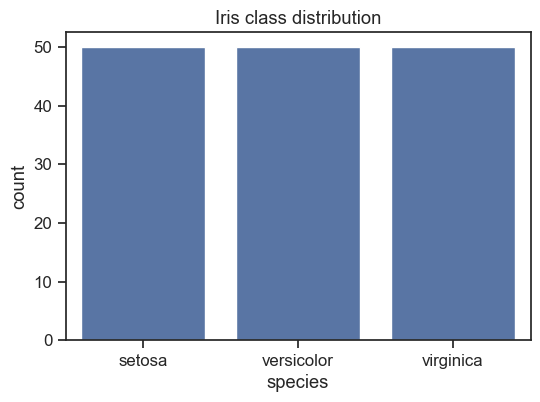

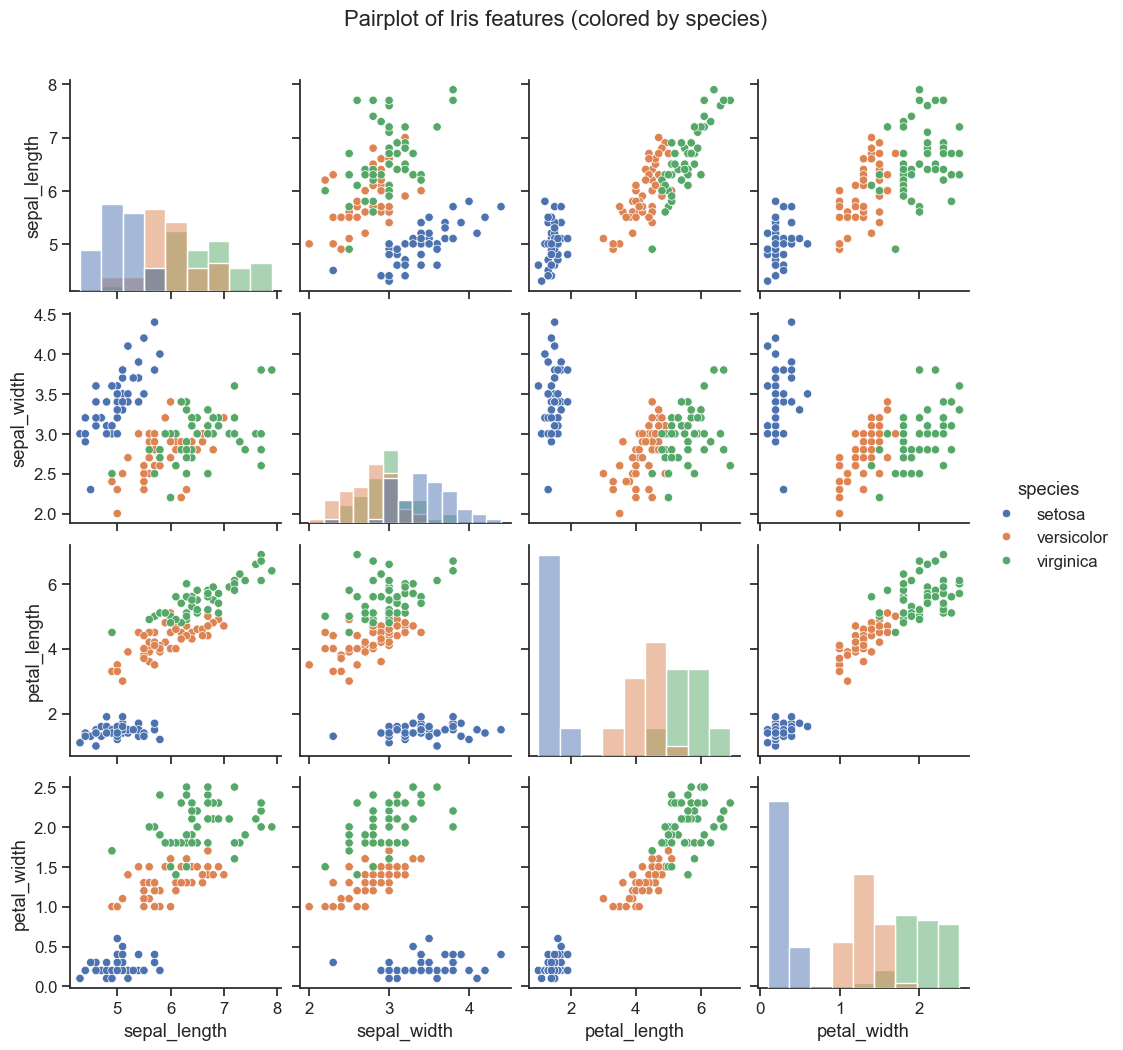

In [5]:
# Cell 4 — class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='species', data=df)
plt.title('Iris class distribution')
plt.show()

# Cell 5 — pairplot (seaborn)
sns.pairplot(df, hue='species', diag_kind='hist', corner=False)
plt.suptitle('Pairplot of Iris features (colored by species)', y=1.05)
plt.show()


In [6]:
# Cell 6 — prepare X, y and split
X = df[cols].values
le = LabelEncoder()
y = le.fit_transform(df['species'])   # numeric labels 0,1,2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (120, 4) Test shape: (30, 4)


In [7]:
# Cell 7 — scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Cell 8 — try multiple k values and collect test accuracy
from collections import OrderedDict

ks = [1, 3, 5, 7]
results = []

for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results.append({'k': k, 'accuracy': acc, 'model': clf})

# show results
for r in results:
    print(f"k={r['k']:2d}  test accuracy = {r['accuracy']:.4f}")


k= 1  test accuracy = 0.9667
k= 3  test accuracy = 0.9333
k= 5  test accuracy = 0.9333
k= 7  test accuracy = 0.9667


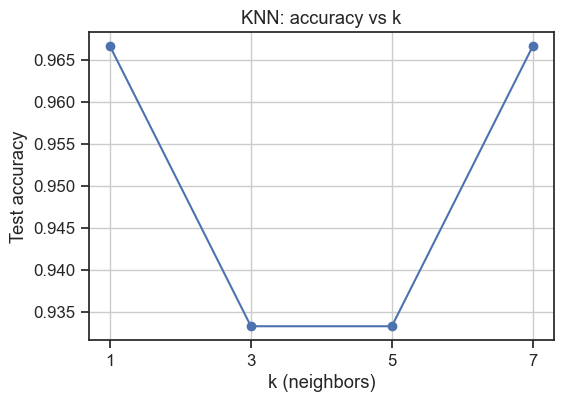

In [9]:
# Cell 9 — accuracy vs k plot
k_vals = [r['k'] for r in results]
accs = [r['accuracy'] for r in results]

plt.figure(figsize=(6,4))
plt.plot(k_vals, accs, marker='o')
plt.xticks(k_vals)
plt.xlabel('k (neighbors)')
plt.ylabel('Test accuracy')
plt.title('KNN: accuracy vs k')
plt.grid(True)
plt.show()


Best k: 1

Classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.91      1.00      0.95        10
   virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



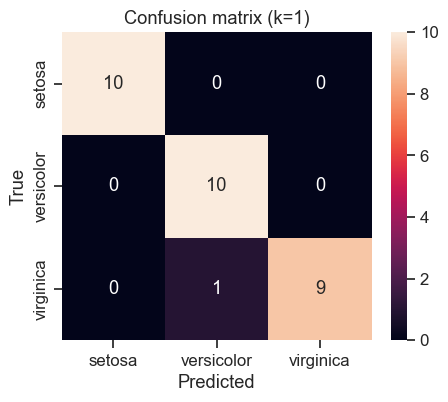

In [10]:
# Cell 10 — detailed eval for best k
best = max(results, key=lambda x: x['accuracy'])
best_k = best['k']
best_clf = best['model']
y_pred_best = best_clf.predict(X_test_scaled)

print("Best k:", best_k)
print("\nClassification report:")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

# confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion matrix (k={best_k})')
plt.show()


In [11]:
# Cell 11 — optional: 5-fold CV to compare k
from sklearn.model_selection import cross_val_score
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, scaler.transform(X), y, cv=5)
    print(f"k={k}: CV mean acc = {scores.mean():.4f} (+/- {scores.std():.4f})")


k=1: CV mean acc = 0.9467 (+/- 0.0340)
k=3: CV mean acc = 0.9533 (+/- 0.0340)
k=5: CV mean acc = 0.9600 (+/- 0.0249)
k=7: CV mean acc = 0.9600 (+/- 0.0327)


In [12]:
# Cell 11 — optional: 5-fold CV to compare k
from sklearn.model_selection import cross_val_score
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, scaler.transform(X), y, cv=5)
    print(f"k={k}: CV mean acc = {scores.mean():.4f} (+/- {scores.std():.4f})")


k=1: CV mean acc = 0.9467 (+/- 0.0340)
k=3: CV mean acc = 0.9533 (+/- 0.0340)
k=5: CV mean acc = 0.9600 (+/- 0.0249)
k=7: CV mean acc = 0.9600 (+/- 0.0327)
